# Complex Data Analysis Project
### Group 7
* Tommaso Tragno - fc64699
* Antonio Alampi - fc64316
* Meike Veen - fc64408

In [2]:
# netowrks
import networkx as nx
import igraph as ig

# data processing
import pandas as pd
import numpy as np
import random

#some functions to make our lifes easier
import sys
sys.path.append("../")
from common_functions import *

# viz
#import pylab as plt
import matplotlib.pyplot as plt
import seaborn as sns

# gzip
import gzip
import statistics

from scipy.sparse import diags, csr_matrix, linalg

import time

#import directedlouvain as dl
#import utils
import simulation

from collections import defaultdict, Counter

# Graph creation

In [3]:
# Path to file
file_path = 'soc-Epinions1.txt'

# Initialize a directed graph
G = nx.DiGraph()

# Load the edge list into the directed graph
with open(file_path, 'r') as f:
    # Skip header lines that start with '#'
    edges = [line.strip().split('\t') for line in f if not line.startswith('#')]
    # Add edges to the graph
    G.add_edges_from((int(src), int(dst)) for src, dst in edges)

## Dataset Statistics

In [4]:
def graph_stats(G):
    is_directed = G.is_directed()
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()

    # Extract the largest Weakly Connected Component (WCC)
    largest_wcc = max(nx.weakly_connected_components(G), key=len)
    G_wcc = G.subgraph(largest_wcc).copy()
    wcc_num_nodes = G_wcc.number_of_nodes()
    wcc_num_edges = G_wcc.number_of_edges()

    # Extract the largest Strongly Connected Component (SCC)
    largest_scc = max(nx.strongly_connected_components(G), key=len)
    G_scc = G.subgraph(largest_scc).copy()
    scc_num_nodes = G_scc.number_of_nodes()
    scc_num_edges = G_scc.number_of_edges()

    avg_clustering_coeff = nx.average_clustering(G)

    if is_directed:
        # Calculate directed triangles
        num_triangles = 0
        for u in G:
            for v in G.successors(u):
                for w in G.successors(v):
                    if G.has_edge(w, u):  # Check for the cycle u -> v -> w -> u
                        num_triangles += 1
        num_triangles = num_triangles // 3  # Each triangle is counted three times

        # Calculate diameter on the largest SCC
        try:
            diameter = nx.diameter(G_wcc)
        except nx.NetworkXError:
            diameter = float('inf')  # If no diameter can be computed

        assortativity = nx.degree_assortativity_coefficient(G_wcc)

    else:
        # Undirected graph
        num_triangles = sum(nx.triangles(G).values()) // 3
        diameter = nx.diameter(G)
        assortativity = nx.degree_assortativity_coefficient(G)

    # Print statistics
    print("Is Directed:", is_directed)
    print("Total Nodes:", num_nodes)
    print("Total Edges:", num_edges)
    print("Nodes in largest WCC:", wcc_num_nodes)
    print("Edges in largest WCC:", wcc_num_edges)
    print("Nodes in largest SCC:", scc_num_nodes)
    print("Edges in largest SCC:", scc_num_edges)
    print("Average clustering coefficient:", avg_clustering_coeff)
    print("Number of triangles:", num_triangles)
    print("Diameter (longest shortest path):", diameter)
    print("Assortatativity Coefficient:", assortativity)

In [7]:
graph_stats(G)

Is Directed: True
Total Nodes: 75879
Total Edges: 508837
Nodes in largest WCC: 75877
Edges in largest WCC: 508836
Nodes in largest SCC: 32223
Edges in largest SCC: 443506
Average clustering coefficient: 0.11017387558244757
Number of triangles: 740310
Diameter (longest shortest path): inf
Assortatativity Coefficient: 0.06389680395789947


## Degree analysis

In [5]:
def compute_degree(graph):
    # Compute in-degree and out-degree for each node
    degree_data = {
        "Node": [],
        "In-Degree": [],
        "Out-Degree": []
    }
    degrees = []

    for node in graph.nodes:
        in_degree = graph.in_degree(node)
        out_degree = graph.out_degree(node)
        degree_data["Node"].append(node)
        degree_data["In-Degree"].append(in_degree)
        degree_data["Out-Degree"].append(out_degree)
        degrees.append(in_degree+out_degree)

    print('Mean degree:', statistics.mean(degrees))
    print('Median degree:', statistics.median(degrees))
    del degrees

    #Create an adjacency list from G
    AdjG = nx.to_dict_of_lists(graph)

    # Compute the log log degree distribution
    out_degrees = {node: len(neighbors) for node, neighbors in AdjG.items()}
    edge_list = [(source, target) for source, targets in AdjG.items() for target in targets]
    in_degree_counts = Counter(target for _, target in edge_list)
    out_degree_distribution = Counter(out_degrees.values())
    in_degree_distribution = Counter(in_degree_counts.values())

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(8, 8))

    # Out-degree distribution
    axes[0].scatter(out_degree_distribution.keys(), out_degree_distribution.values(), color="black", s=10)
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")
    axes[0].set_title("Log-Log Out-Degree Distribution")
    axes[0].set_xlabel("Degree (log scale)")
    axes[0].set_ylabel("Number of Nodes (log scale)")
    axes[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

    # In-degree distribution
    axes[1].scatter(in_degree_distribution.keys(), in_degree_distribution.values(), color="black", s=10)
    axes[1].set_xscale("log")
    axes[1].set_yscale("log")
    axes[1].set_title("Log-Log In-Degree Distribution")
    axes[1].set_xlabel("Degree (log scale)")
    axes[1].set_ylabel("Number of Nodes (log scale)")
    axes[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    return degree_data

Mean degree: 13.411800366372777
Median degree: 2


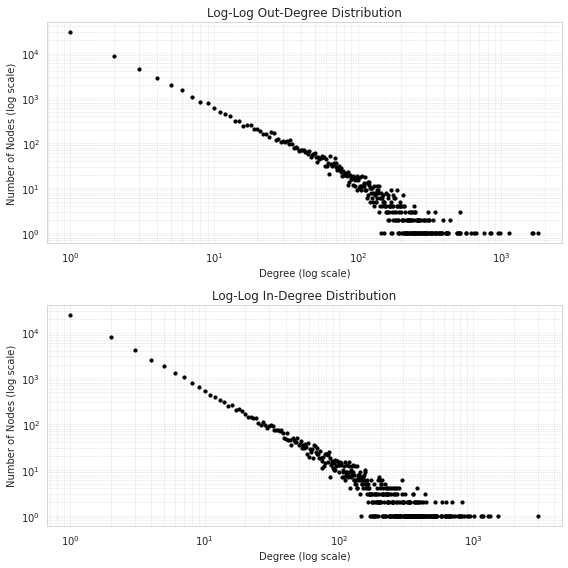

In [9]:
degree_data = compute_degree(G)

In [ ]:
# Convert results to a pandas DataFrame for easier analysis and viewing
degree_df = pd.DataFrame(f'degree_data/{degree_data}')
degree_df.head()  # Display the first few rows

# Save the DataFrame to a CSV file
degree_df.to_csv('graph_degrees.csv', index=False)

## Hub finding:
* most trusted nodes
* most trusting nodes
* both trusted and truster

In [6]:
def find_hubs(degree_data, top_n=5, threshold=600):
    """
    Identify top hubs by in-degree and out-degree.

    Args:
        degree_data (dict): A dictionary containing "Node", "In-Degree", and "Out-Degree".
        top_n (int): Number of top nodes to return by in-degree and out-degree.
        threshold (int): Minimum in-degree and out-degree for filtering hubs.

    Returns:
        dict: A dictionary with lists of hubs:
              {
                "top_in_degree": [(node, in_degree, out_degree)],
                "top_out_degree": [(node, in_degree, out_degree)],
                "top_in_out_degree": [(node, in_degree, out_degree)]
              }
    """
    node_data = list(zip(degree_data["Node"], degree_data["In-Degree"], degree_data["Out-Degree"]))

    # Sort by In-Degree in descending order and take the top N
    top_in_degree = sorted(node_data, key=lambda x: x[1], reverse=True)[:top_n]

    # Sort by Out-Degree in descending order and take the top N
    top_out_degree = sorted(node_data, key=lambda x: x[2], reverse=True)[:top_n]

    # Nodes with both In-Degree and Out-Degree above the threshold
    top_in_out_degree = [
        (node, in_degree, out_degree)
        for node, in_degree, out_degree in node_data
        if in_degree > threshold and out_degree > threshold
    ]

    return {
        "top_in_degree": top_in_degree,
        "top_out_degree": top_out_degree,
        "top_in_out_degree": top_in_out_degree
    }

In [81]:
hubs = find_hubs(degree_data, threshold=600)

# Results can also be used programmatically
print("Top by In-Degree:", hubs["top_in_degree"])
print("Top by Out-Degree:", hubs["top_out_degree"])
print("Nodes above threshold:", hubs["top_in_out_degree"])

Top by In-Degree: [(645, 1632, 390), (634, 1350, 351), (763, 1053, 251), (71399, 932, 109), (3924, 901, 92)]
Top by Out-Degree: [(18, 44, 2761), (143, 143, 1438), (737, 370, 1199), (790, 102, 1193), (1179, 85, 1119)]
Nodes above threshold: [(44, 808, 627)]


## Hub Analysis

In [82]:
def analize_hubs(G, node_a, node_b):
    # Check if the hubs are connected
    if G.has_edge(node_a, node_b):
        print(f'The hubs {node_a} and {node_b} are directly connected.')
    else:
        print(f'The hubs {node_a} and {node_b} are not directly connected.')
        
        # If not directly connected, find the shortest path (if it exists)
        try:
            path = nx.shortest_path(G, node_a, node_b)
            print(f'The shortest path between {node_a} and {node_b} is: {path}')
        except nx.NetworkXNoPath:
            print(f'There is no path between {node_a} and {node_b}.')

    # Get the predecessors of the target nodes
    predecessors_a = set(G.predecessors(node_a))
    predecessors_b = set(G.predecessors(node_b))

    # Find nodes that have outgoing edges to both target nodes
    common_predecessors = predecessors_a & predecessors_b

    # Output the result
    print(f'There are {len(common_predecessors)} nodes with outgoing edges to both {node_a} and {node_b}: {common_predecessors}')

In [83]:
analize_hubs(G,18,143)

The hubs 18 and 143 are not directly connected.
The shortest path between 18 and 143 is: [18, 128, 143]
There are 588 nodes with outgoing edges to both 18 and 143: {4100, 2055, 2057, 4110, 6159, 16, 10259, 2069, 27, 31, 16416, 33, 36, 2084, 39, 2088, 2097, 2103, 58, 62, 65, 67, 4165, 4167, 6215, 77, 79, 82, 83, 85, 4182, 10330, 91, 4187, 4188, 8288, 2144, 10338, 99, 12388, 4197, 14438, 4199, 2152, 4200, 4202, 107, 2157, 112, 18544, 119, 2167, 71801, 8316, 124, 126, 128, 8321, 10378, 140, 141, 2189, 6285, 145, 146, 8344, 2201, 172, 10413, 2226, 37043, 2231, 2232, 18620, 198, 4295, 12496, 212, 215, 217, 4313, 2270, 223, 225, 2277, 6374, 8423, 232, 2279, 30953, 6378, 4333, 4334, 239, 2287, 6382, 8434, 6383, 6393, 6397, 6402, 2308, 14600, 4368, 6419, 2329, 290, 291, 4394, 8491, 24877, 8495, 4406, 318, 320, 2369, 4418, 329, 340, 342, 343, 6487, 348, 8541, 356, 2410, 375, 379, 45439, 384, 385, 57728, 2433, 4482, 6527, 8592, 6555, 418, 8613, 2470, 2471, 431, 4527, 4537, 443, 445, 447, 14783, 

## Degree Centrality

In [84]:
# Degree centrality
degree_centrality = nx.degree_centrality(G)
print("Top 20 nodes by degree centrality:", sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:20])

Top 20 nodes by degree centrality: [(18, 0.04057829673950289), (645, 0.029112522733862254), (634, 0.026344922111811067), (763, 0.02585729724030681), (143, 0.022298953583383855), (737, 0.022259416431640266), (44, 0.019966261630512138), (790, 0.018266164105537837), (34, 0.01730409341311052), (136, 0.017014154300324207), (1179, 0.01648699227707636), (71399, 0.01639473892300799), (27, 0.01618387411370885), (1719, 0.01563035398929861), (1516, 0.014931864308495217), (118, 0.01485279000500804), (1, 0.01478689475210206), (637, 0.014523313740478137), (3924, 0.014075226020717467), (40, 0.013903898363161919)]


# Core network

In [9]:
def get_core_nodes(graph, threshold):
    """
    Recursively removes nodes with in-degree + out-degree < threshold and returns the core graph.
    
    Parameters:
    - graph: A NetworkX DiGraph (directed graph)
    
    Returns:
    - A NetworkX DiGraph representing the core of the network
    """
    # Create a copy of the graph to avoid modifying the original
    core_graph = graph.copy()
    
    count = 0
    number_of_removed = 0
    while True:
        # Identify nodes with in-degree + out-degree < threshold
        nodes_to_remove = [
            node for node in core_graph.nodes 
            if core_graph.in_degree(node) + core_graph.out_degree(node) < threshold
        ]
        
        # Exit condition - if no nodes meet the condition, stop the process
        if not nodes_to_remove:
            break
        
        # Remove the identified nodes
        core_graph.remove_nodes_from(nodes_to_remove)
        number_of_removed += len(nodes_to_remove)
        print(f'Iteration {count}: removed {len(nodes_to_remove)} nodes')
        count += 1
    print(f'Executed {count} iterations, removed {number_of_removed} nodes')
    return core_graph

In [10]:
# Get the core graph
threshold = 4
core_G = get_core_nodes(G, threshold)
# Print the number of nodes and edges in the original and core graphs
print(f"Original Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Core Graph: {core_G.number_of_nodes()} nodes, {core_G.number_of_edges()} edges")

nx.write_edgelist(core_G, "core_g_edge_list.txt", data=False)

Iteration 0: removed 49243 nodes
Iteration 1: removed 2772 nodes
Iteration 2: removed 309 nodes
Iteration 3: removed 44 nodes
Iteration 4: removed 8 nodes
Executed 5 iterations, removed 52376 nodes
Original Graph: 75879 nodes, 508837 edges
Core Graph: 23503 nodes, 431564 edges


In [92]:
graph_stats(core_G)

Is Directed: True
Total Nodes: 433
Total Edges: 34213
Nodes in largest WCC: 433
Edges in largest WCC: 34213
Nodes in largest SCC: 432
Edges in largest SCC: 34096
Average clustering coefficient: 0.30159020719278284
Number of triangles: 246277
Diameter (longest shortest path): 3


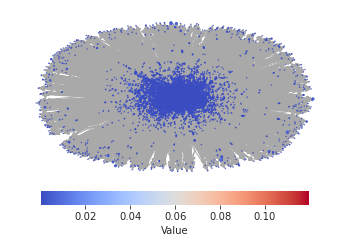

In [6]:
plot_network(core_G, with_labels=False)

The core graph has the 30,87% of node of the original graph. Let's calculate mean and median degree.

## Degree Analysis

Mean degree: 36.72416287282475
Median degree: 10


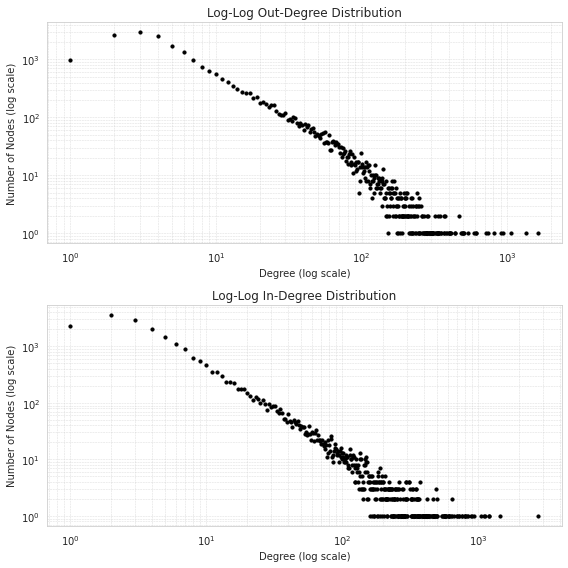

In [12]:
core_degree_data = compute_degree(core_G)

Mean and median are higher respect the mean and the median of the original graph (plausible)

In [ ]:
# Convert results to a pandas DataFrame for easier analysis and viewing
degree_df = pd.DataFrame(f'degree_data/{core_degree_data}')
degree_df.head()  # Display the first few rows

# Save the DataFrame to a CSV file
degree_df.to_csv('core_node_degrees.csv', index=False)

## Hub Finding - Core Graph

In [87]:
core_hubs = find_hubs(core_degree_data, threshold=600)

# Results can also be used programmatically
print("Top by In-Degree:", core_hubs["top_in_degree"])
print("Top by Out-Degree:", core_hubs["top_out_degree"])
print("Nodes above threshold:", core_hubs["top_in_out_degree"])

Top by In-Degree: [(645, 1632, 390), (634, 1350, 351), (763, 1053, 251), (71399, 932, 109), (3924, 901, 92)]
Top by Out-Degree: [(18, 44, 2761), (143, 143, 1438), (737, 370, 1199), (790, 102, 1193), (1179, 85, 1119)]
Nodes above threshold: [(44, 808, 627)]


## Hub Analysis - Core Graph

In [88]:
analize_hubs(core_G, 18, 143)

The hubs 18 and 143 are not directly connected.
The shortest path between 18 and 143 is: [18, 128, 143]
There are 588 nodes with outgoing edges to both 18 and 143: {4100, 2055, 2057, 4110, 6159, 16, 10259, 2069, 27, 31, 16416, 33, 36, 2084, 39, 2088, 2097, 2103, 58, 62, 65, 67, 4165, 4167, 6215, 77, 79, 82, 83, 85, 4182, 10330, 91, 4187, 4188, 8288, 2144, 10338, 99, 12388, 4197, 14438, 4199, 2152, 4200, 4202, 107, 2157, 112, 18544, 119, 2167, 71801, 8316, 124, 126, 128, 8321, 10378, 140, 141, 2189, 6285, 145, 146, 8344, 2201, 172, 10413, 2226, 37043, 2231, 2232, 18620, 198, 4295, 12496, 212, 215, 217, 4313, 2270, 223, 225, 2277, 6374, 8423, 232, 2279, 30953, 6378, 4333, 4334, 239, 2287, 6382, 8434, 6383, 6393, 6397, 6402, 2308, 14600, 4368, 6419, 2329, 290, 291, 4394, 8491, 24877, 8495, 4406, 318, 320, 2369, 4418, 329, 340, 342, 343, 6487, 348, 8541, 356, 2410, 375, 379, 45439, 384, 385, 57728, 2433, 4482, 6527, 8592, 6555, 418, 8613, 2470, 2471, 431, 4527, 4537, 443, 445, 447, 14783, 

## Degree Centrality - Core Graph

In [89]:
# Degree centrality
degree_centrality = nx.degree_centrality(core_G)
print("Top 20 nodes by degree centrality:", sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:20])

Top 20 nodes by degree centrality: [(18, 0.11935154454940004), (645, 0.08603523104416645), (634, 0.07237681899412815), (143, 0.0672708705642073), (737, 0.0667602757212152), (44, 0.06105863330780359), (763, 0.05548463960513999), (34, 0.05514424304314526), (790, 0.055101693472895924), (136, 0.05135733129095396), (1179, 0.05122968258020594), (27, 0.05008084418347374), (1516, 0.047315122117266614), (1719, 0.04676197770402519), (1, 0.04612373415028508), (118, 0.04480469747255553), (71399, 0.04429410262956344), (40, 0.04412390434856608), (4416, 0.04271976853033784), (31, 0.04259211981958982)]


# Reversed core graph

In [11]:
reversed_core_G = core_G.reverse() 

Let's do descriptive statistics for the core graph.

In [44]:
graph_stats(reversed_core_G)

Is Directed: True
Total Nodes: 23503
Total Edges: 431564
Nodes in largest WCC: 23497
Edges in largest WCC: 431552
Nodes in largest SCC: 21498
Edges in largest SCC: 418634
Average clustering coefficient: 0.21951381653187882
Number of triangles: 738999
Diameter (longest shortest path): 14


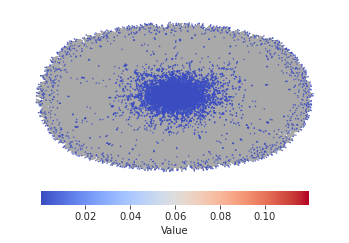

In [9]:
plot_network(reversed_core_G, with_labels=False)

## Degree Analysis

Mean degree: 36.72416287282475
Median degree: 10


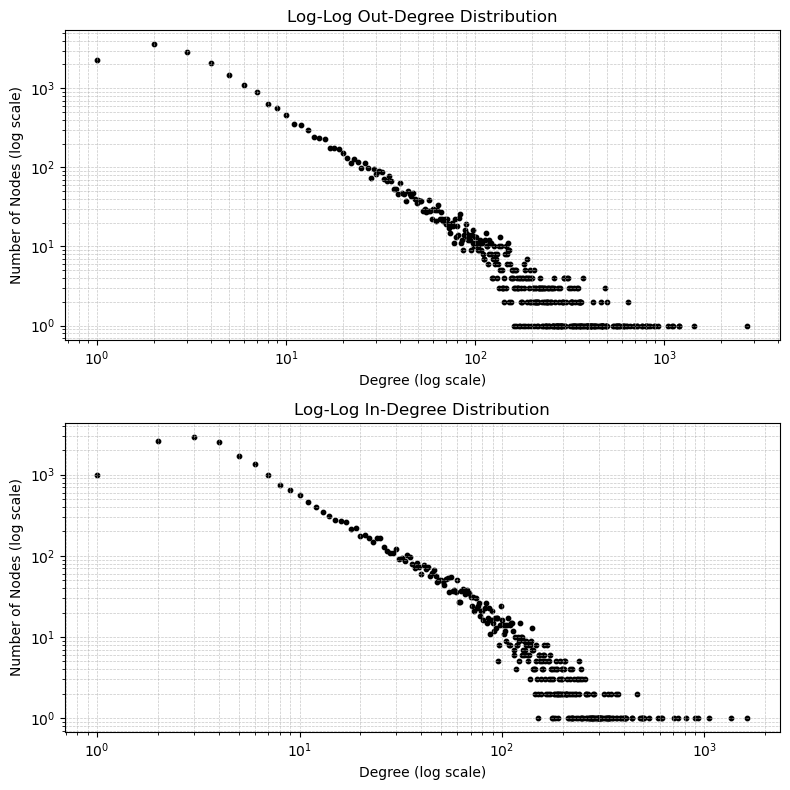

In [92]:
reverse_core_degree_data = compute_degree(reversed_core_G)

Alright, they are the same values for the core graph

In [ ]:
# Convert results to a pandas DataFrame for easier analysis and viewing
degree_df = pd.DataFrame(f'degree_data/{reverse_core_degree_data}')
degree_df.head()  # Display the first few rows

# Save the DataFrame to a CSV file
degree_df.to_csv('reverse_core_node_degrees.csv', index=False)

## Hub Finding - Reverse Core Graph

Let's check the top 5 by in-degree and 5 top nodes by out-degree.

In [94]:
reverse_hubs = find_hubs(reverse_core_degree_data, threshold=600)

# Results can also be used programmatically
print("Top by In-Degree:", reverse_hubs["top_in_degree"])
print("Top by Out-Degree:", reverse_hubs["top_out_degree"])
print("Nodes above threshold:", reverse_hubs["top_in_out_degree"])

Top by In-Degree: [(645, 1632, 390), (634, 1350, 351), (763, 1053, 251), (71399, 932, 109), (3924, 901, 92)]
Top by Out-Degree: [(18, 44, 2761), (143, 143, 1438), (737, 370, 1199), (790, 102, 1193), (1179, 85, 1119)]
Nodes above threshold: [(44, 808, 627)]


The top 5 nodes by in-degree of the core graph now are the top 5 nodes by out-degree of the reversed graph! And vice-versa.

## Hub Analysis - Reverse Core Graph

In [95]:
analize_hubs(reversed_core_G, 18, 143)

The hubs 18 and 143 are directly connected.
There are 1 nodes with outgoing edges to both 18 and 143: {735}


That's weird. Why in the core graph those two hubs were not directly connected, but in the reverse graph thery are?

## Degree Centrality - Reverse Core Graph

In [96]:
# Degree centrality
degree_centrality = nx.degree_centrality(reversed_core_G)
print("Top 20 nodes by degree centrality:", sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:20])

Top 20 nodes by degree centrality: [(18, 0.11935154454940004), (645, 0.08603523104416645), (634, 0.07237681899412815), (143, 0.0672708705642073), (737, 0.0667602757212152), (44, 0.06105863330780359), (763, 0.05548463960513999), (34, 0.05514424304314526), (790, 0.055101693472895924), (136, 0.05135733129095396), (1179, 0.05122968258020594), (27, 0.05008084418347374), (1516, 0.047315122117266614), (1719, 0.04676197770402519), (1, 0.04612373415028508), (118, 0.04480469747255553), (71399, 0.04429410262956344), (40, 0.04412390434856608), (4416, 0.04271976853033784), (31, 0.04259211981958982)]


# Ego graph 

This function extract a subgraph around a node. It is interesting to see a subgraph around the node that has the highest in-degree, i.e. 18.

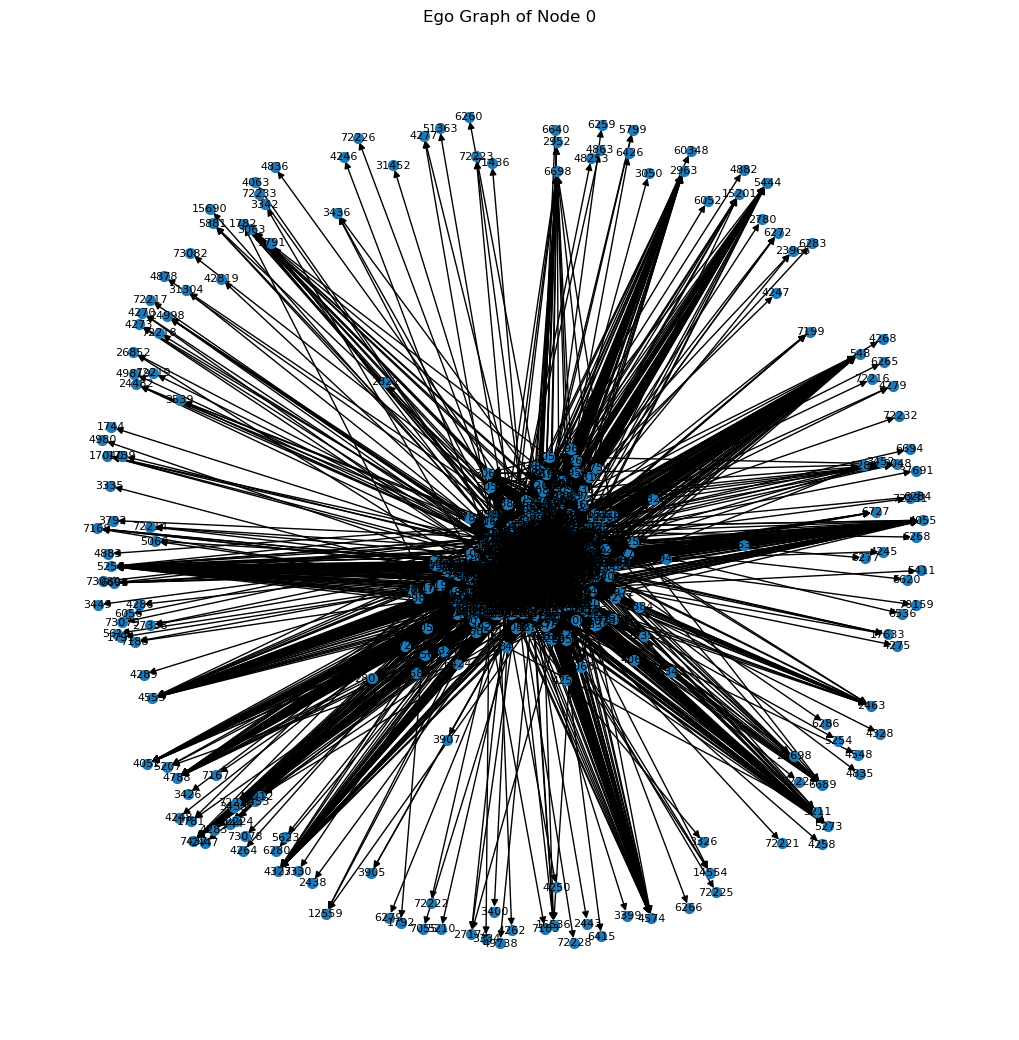

In [6]:
# Extract a subgraph around a node (e.g., ego graph)
node_of_interest = 0
subgraph = nx.ego_graph(G, node_of_interest, radius=2)

# Plot the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph, with_labels=True, node_size=50, font_size=8)
plt.title(f"Ego Graph of Node {node_of_interest}")
plt.show()


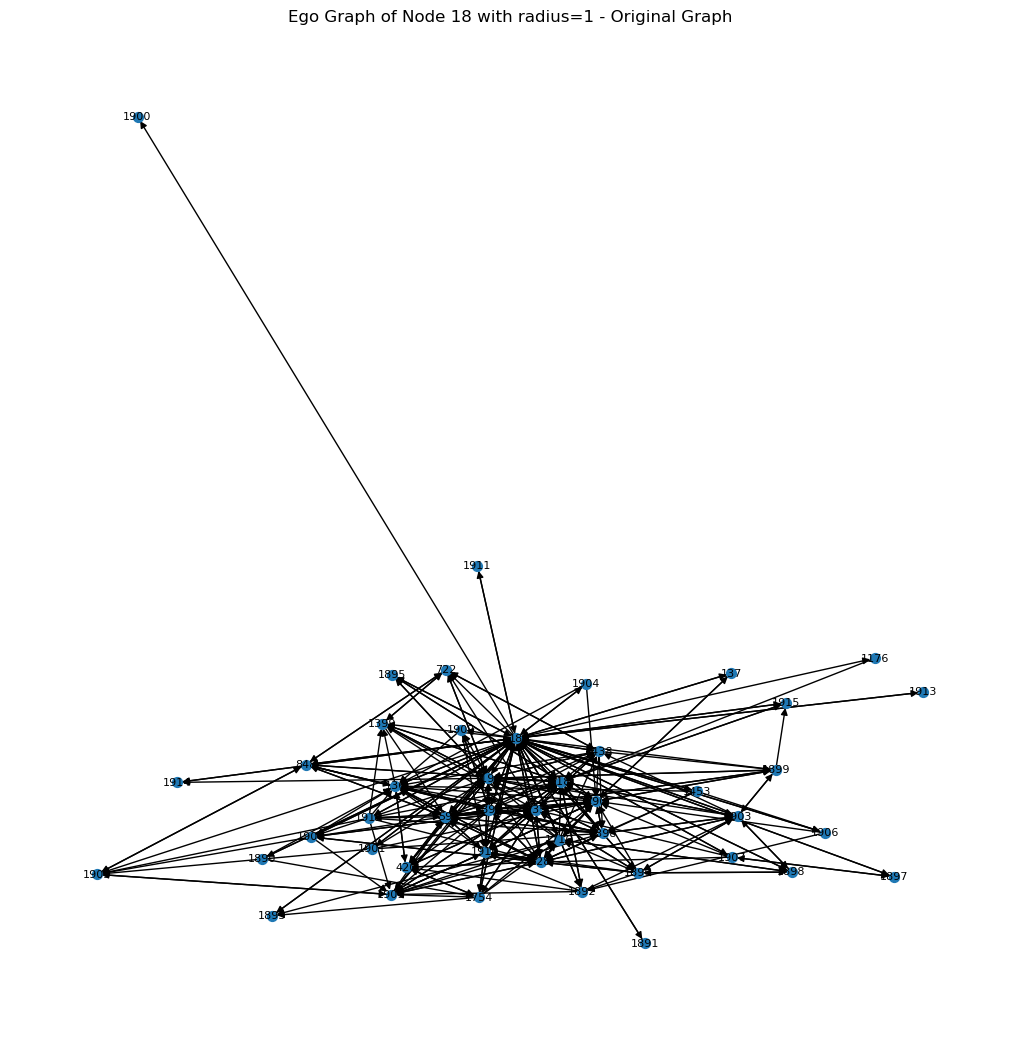

In [53]:
node_of_interest = 18
subgraph = nx.ego_graph(G, node_of_interest, radius=1)

# Plot the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph, with_labels=True, node_size=50, font_size=8)
plt.title(f"Ego Graph of Node {node_of_interest} with radius=1 - Original Graph")
plt.show()

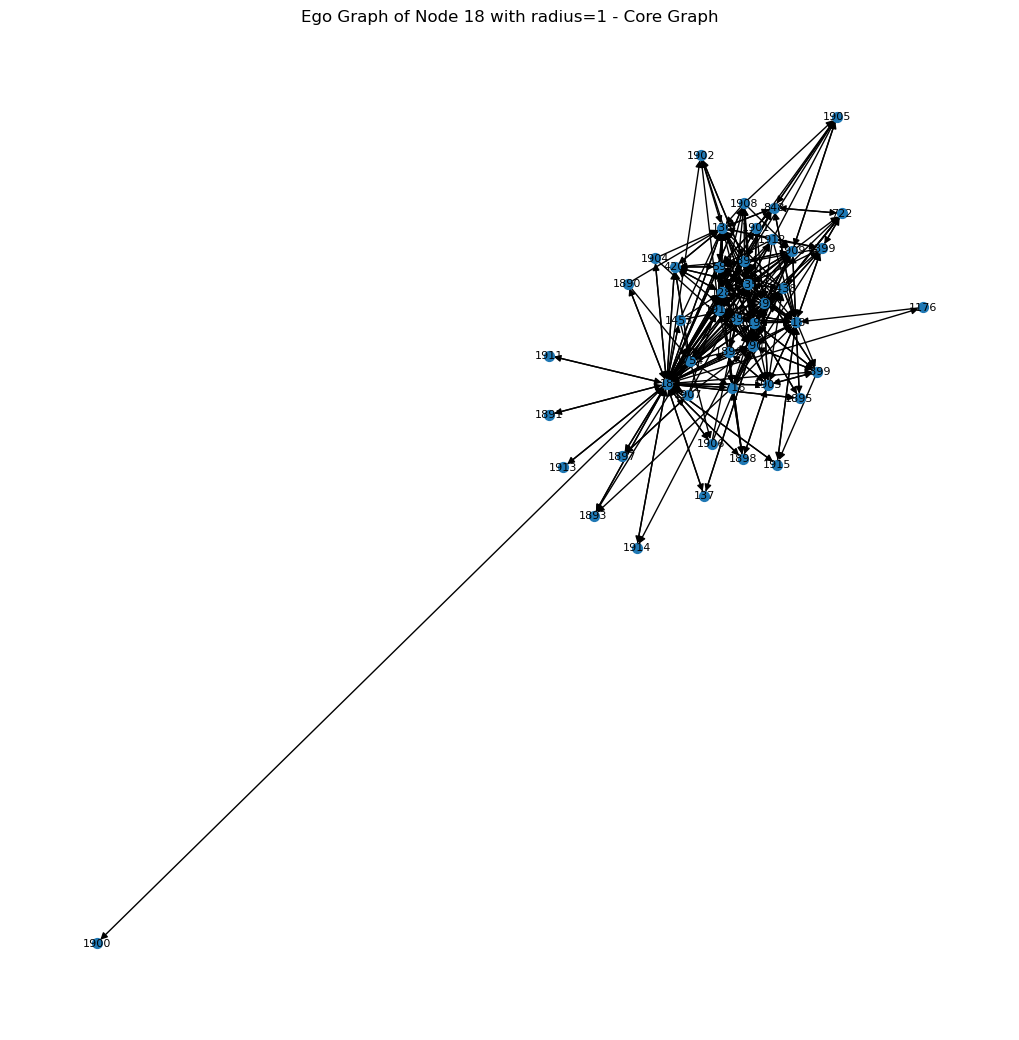

In [58]:
node_of_interest = 18
subgraph = nx.ego_graph(core_G, node_of_interest, radius=1)

# Plot the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph, with_labels=True, node_size=50, font_size=8)
plt.title(f"Ego Graph of Node {node_of_interest} with radius=1 - Core Graph")
plt.show()

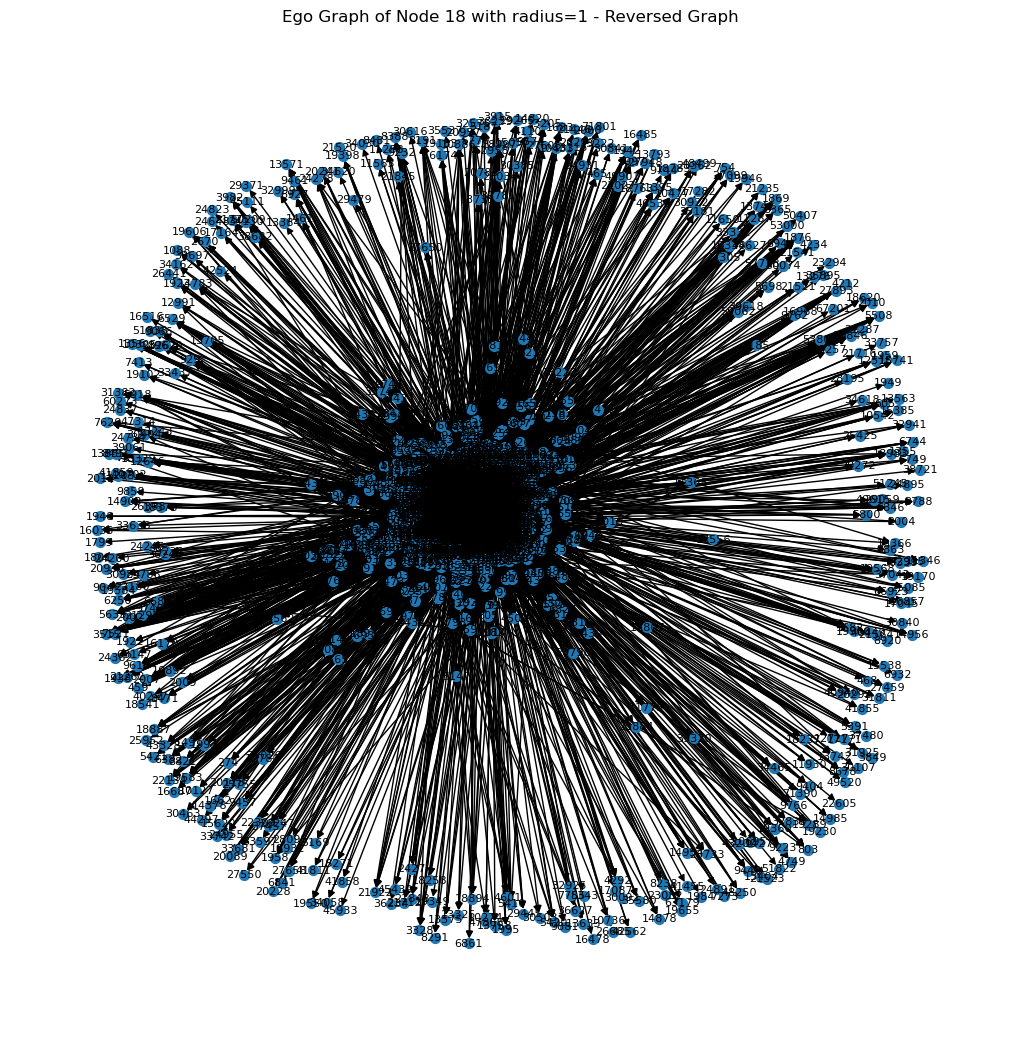

In [56]:
node_of_interest = 18
subgraph = nx.ego_graph(reversed_graph, node_of_interest, radius=1)

# Plot the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph, with_labels=True, node_size=50, font_size=8)
plt.title(f"Ego Graph of Node {node_of_interest} with radius=1 - Reversed Graph")
plt.show()

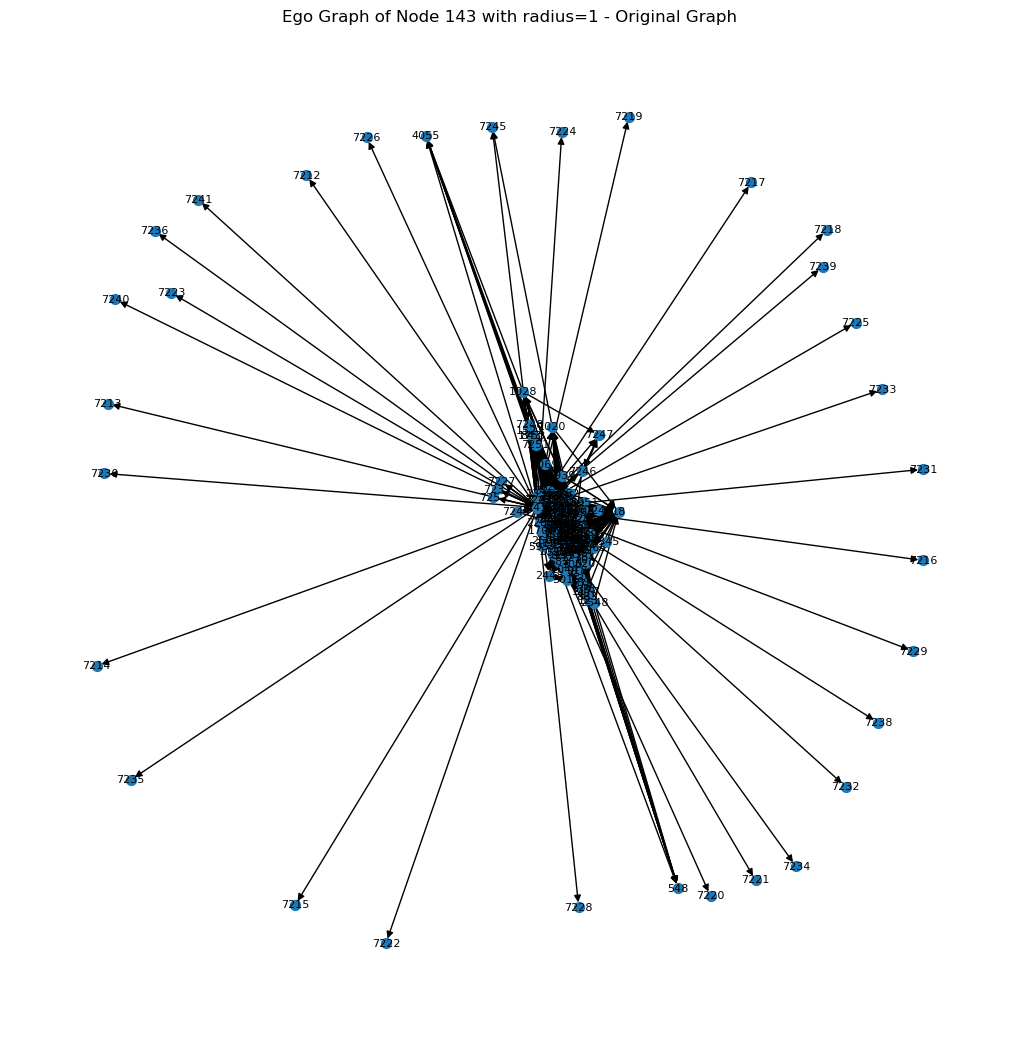

In [59]:
node_of_interest = 143
subgraph = nx.ego_graph(G, node_of_interest, radius=1)

# Plot the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph, with_labels=True, node_size=50, font_size=8)
plt.title(f"Ego Graph of Node {node_of_interest} with radius=1 - Original Graph")
plt.show()

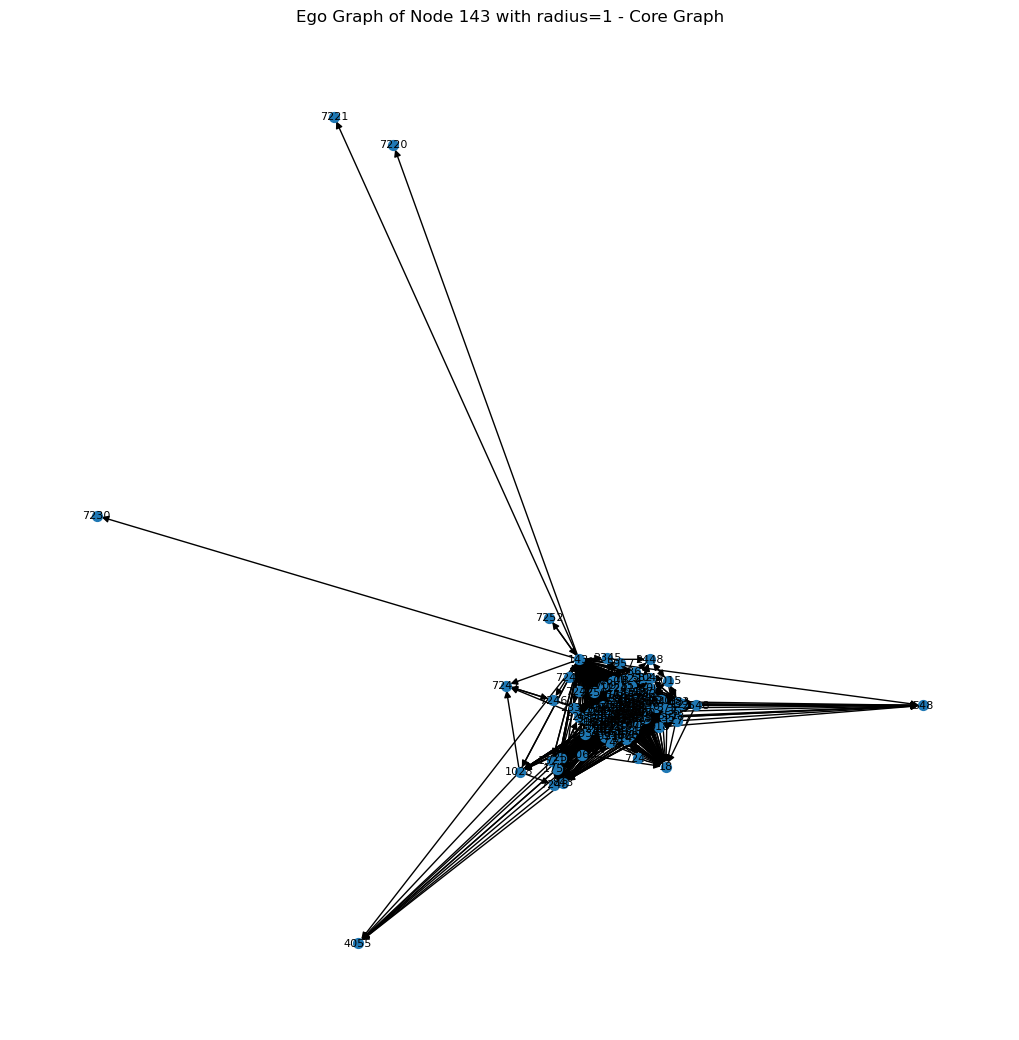

In [62]:
node_of_interest = 143
subgraph = nx.ego_graph(core_G, node_of_interest, radius=1)

# Plot the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph, with_labels=True, node_size=50, font_size=8)
plt.title(f"Ego Graph of Node {node_of_interest} with radius=1 - Core Graph")
plt.show()

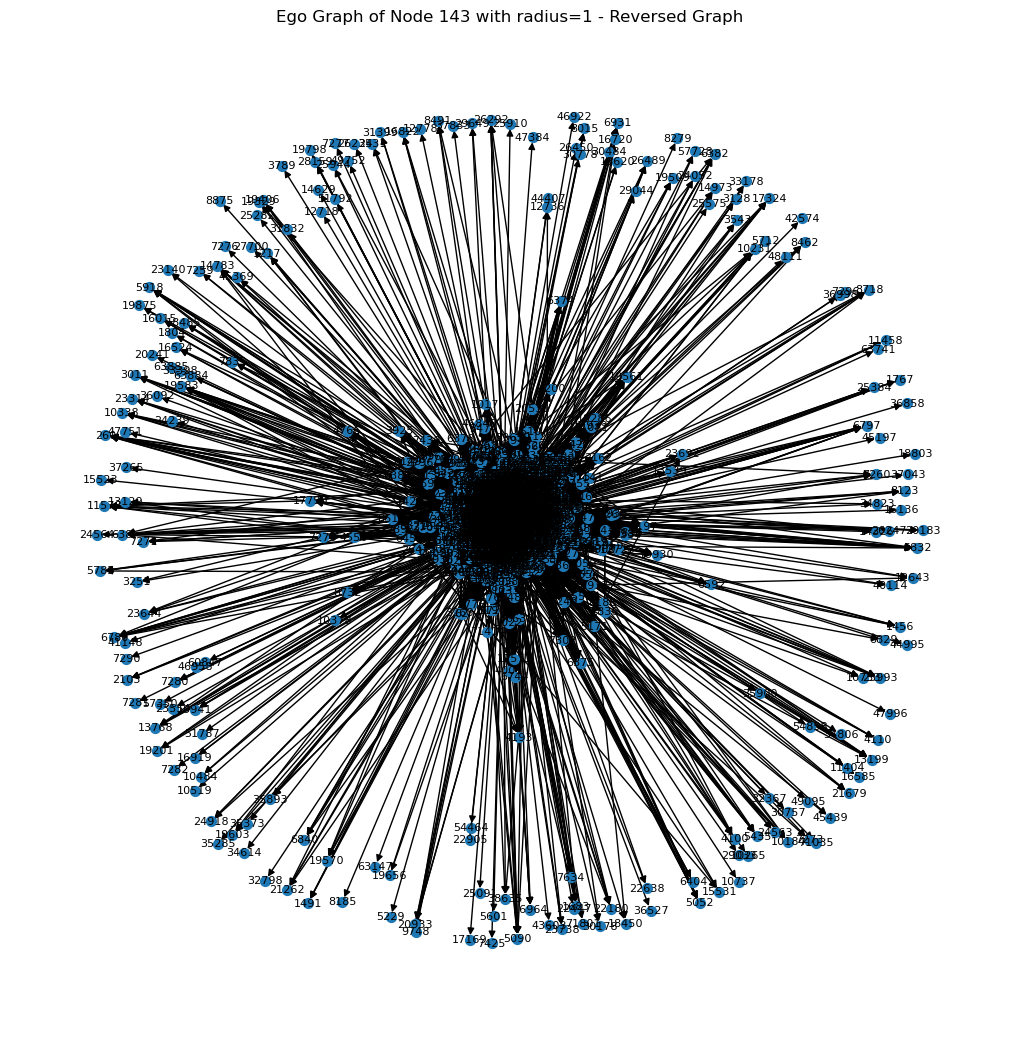

In [63]:
node_of_interest = 143
subgraph = nx.ego_graph(reversed_graph, node_of_interest, radius=1)

# Plot the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph, with_labels=True, node_size=50, font_size=8)
plt.title(f"Ego Graph of Node {node_of_interest} with radius=1 - Reversed Graph")
plt.show()

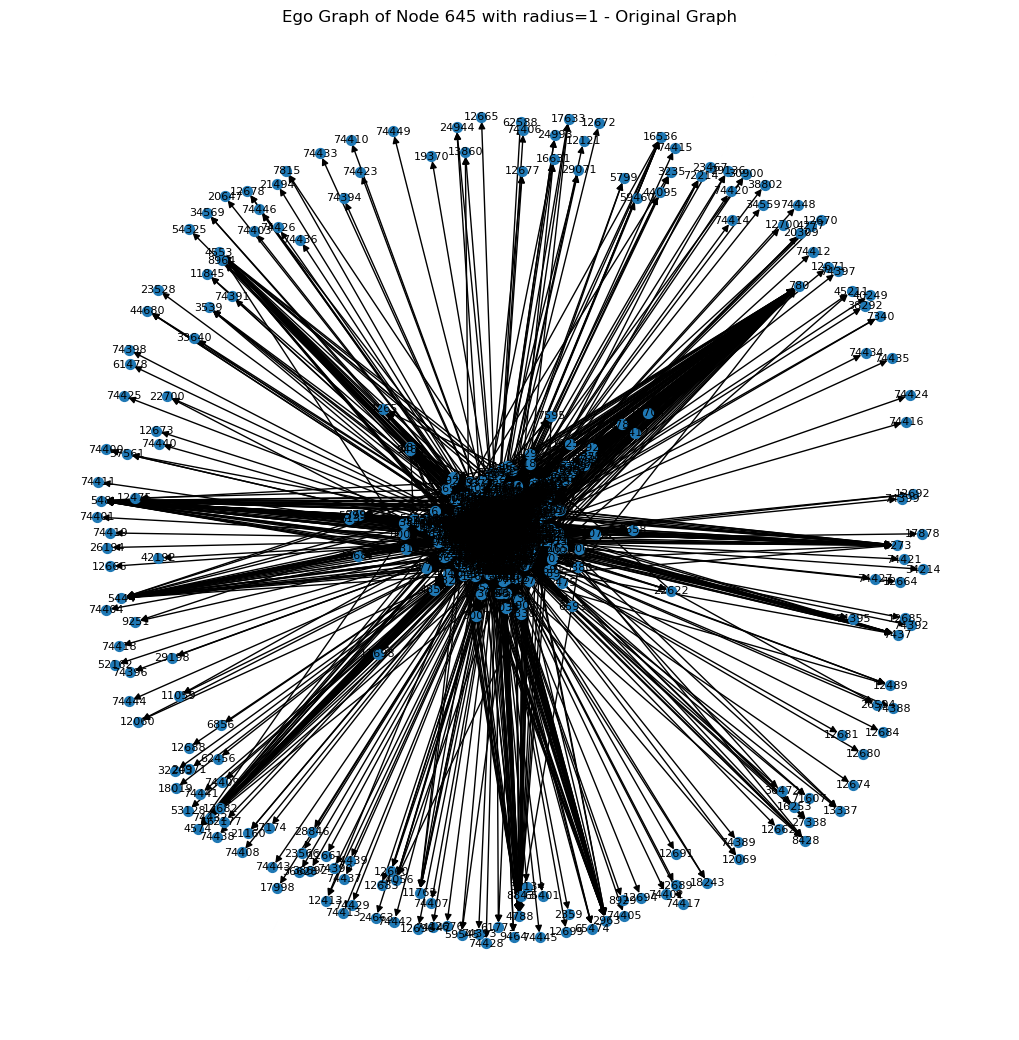

In [64]:
node_of_interest = 645
subgraph = nx.ego_graph(G, node_of_interest, radius=1)

# Plot the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph, with_labels=True, node_size=50, font_size=8)
plt.title(f"Ego Graph of Node {node_of_interest} with radius=1 - Original Graph")
plt.show()

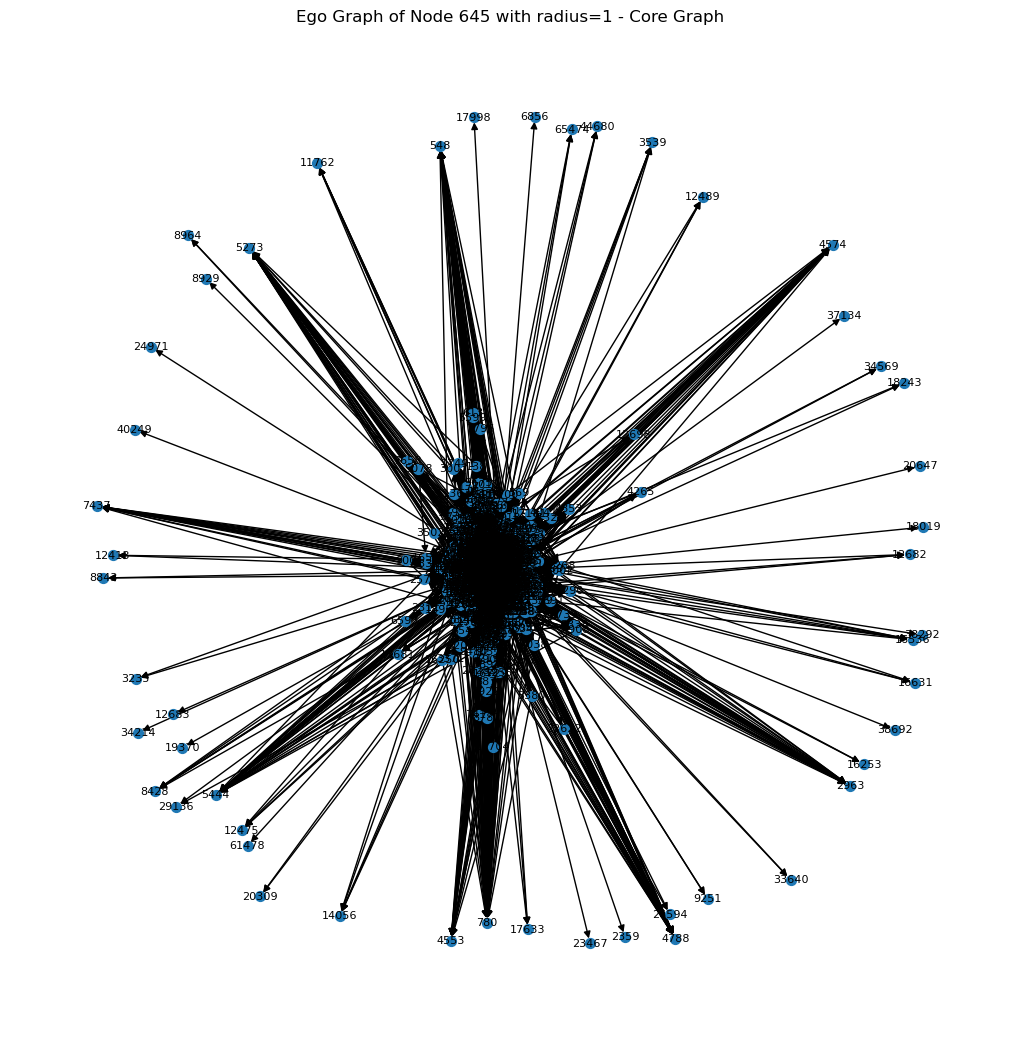

In [66]:
node_of_interest = 645
subgraph = nx.ego_graph(core_G, node_of_interest, radius=1)

# Plot the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph, with_labels=True, node_size=50, font_size=8)
plt.title(f"Ego Graph of Node {node_of_interest} with radius=1 - Core Graph")
plt.show()

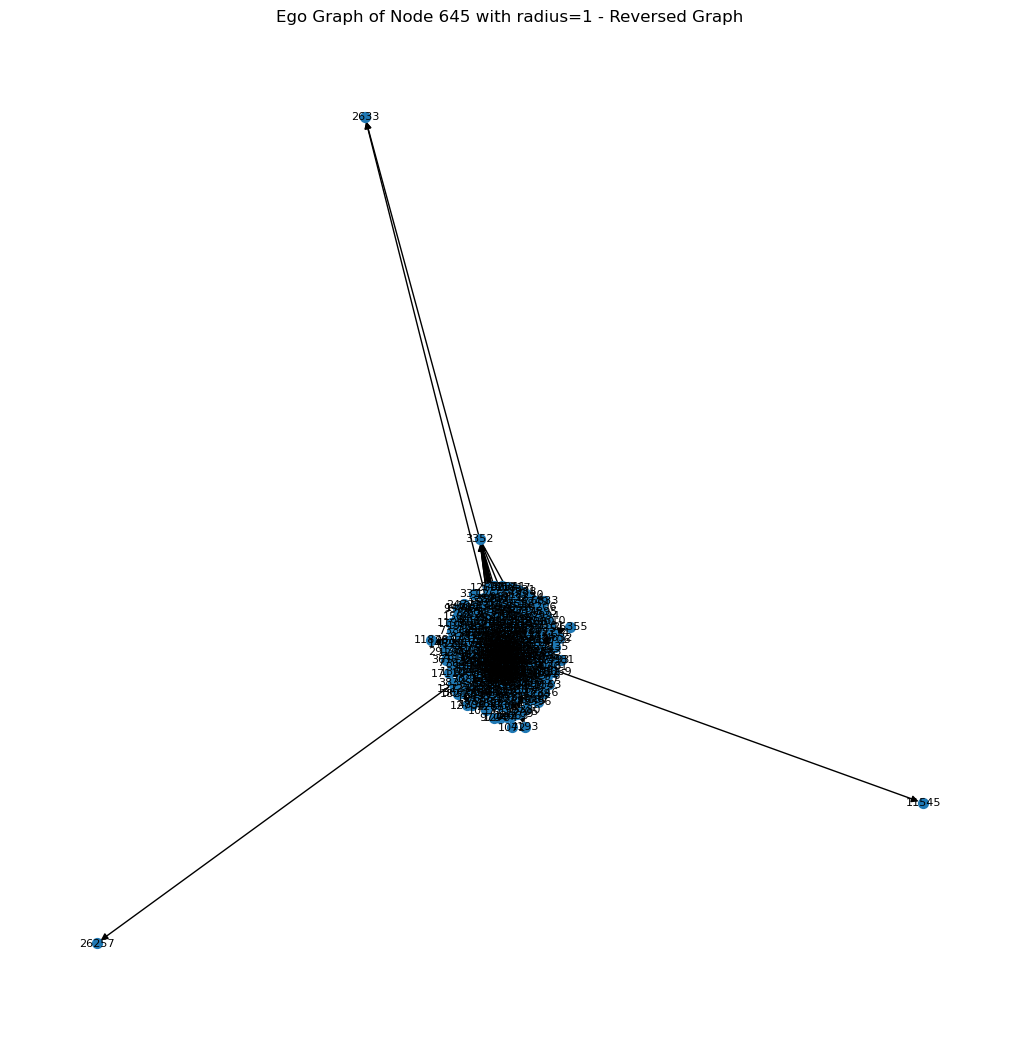

In [65]:
node_of_interest = 645
subgraph = nx.ego_graph(reversed_graph, node_of_interest, radius=1)

# Plot the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph, with_labels=True, node_size=50, font_size=8)
plt.title(f"Ego Graph of Node {node_of_interest} with radius=1 - Reversed Graph")
plt.show()

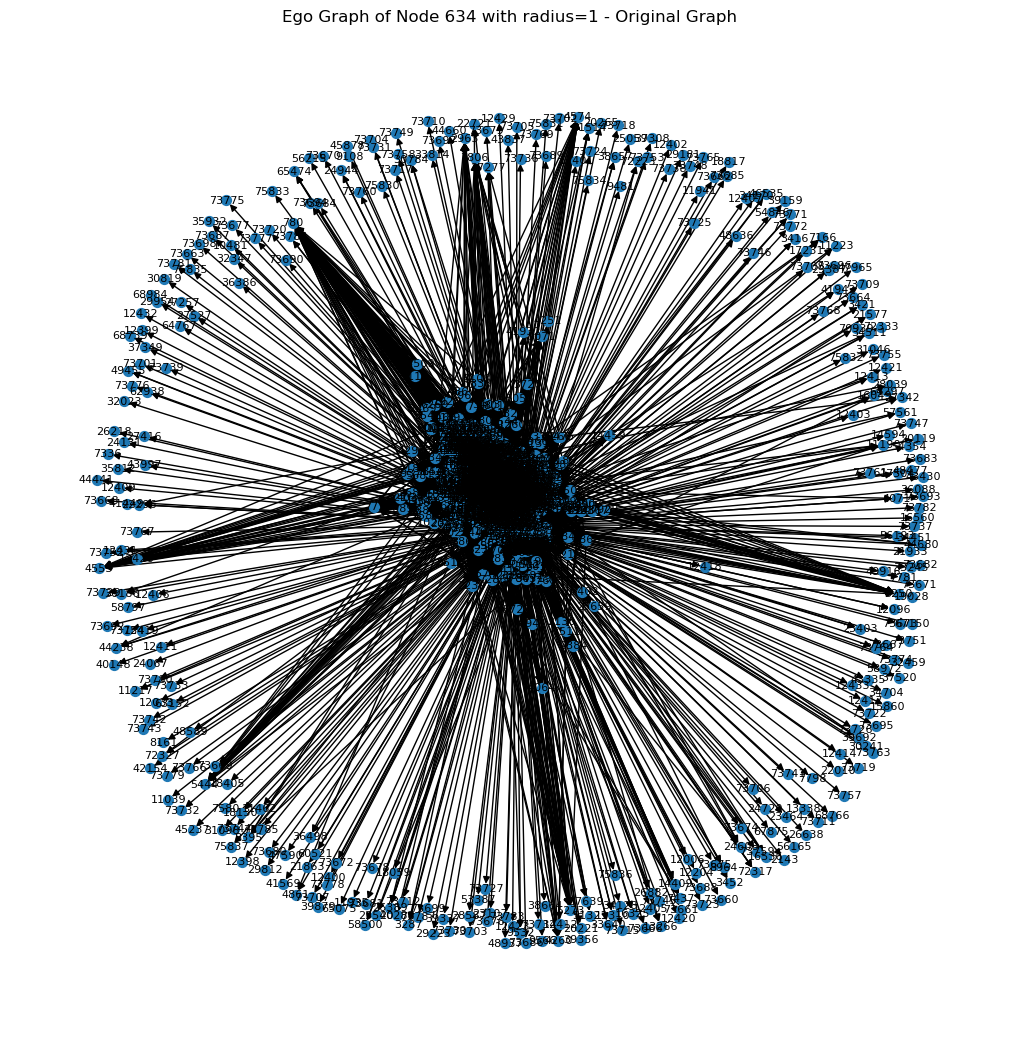

In [67]:
node_of_interest = 634
subgraph = nx.ego_graph(G, node_of_interest, radius=1)

# Plot the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph, with_labels=True, node_size=50, font_size=8)
plt.title(f"Ego Graph of Node {node_of_interest} with radius=1 - Original Graph")
plt.show()

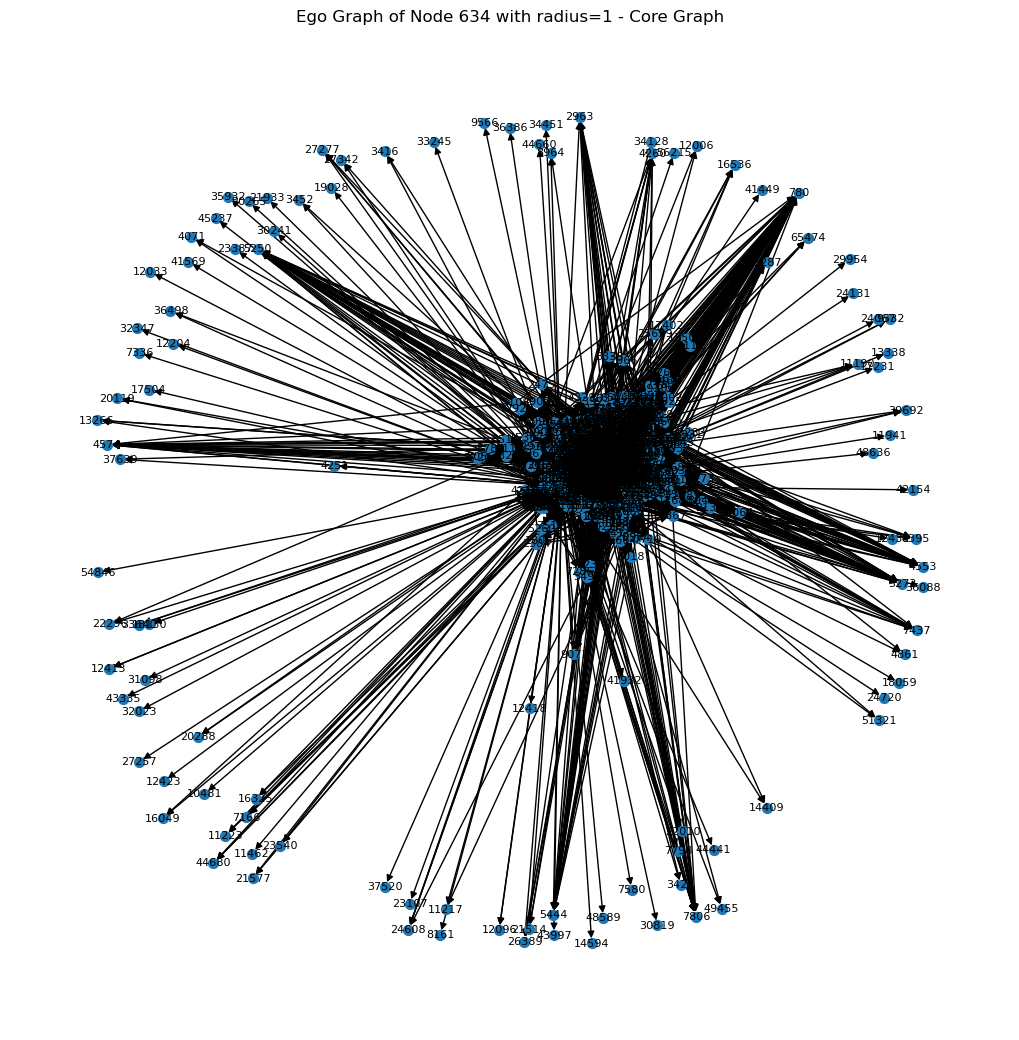

In [68]:
node_of_interest = 634
subgraph = nx.ego_graph(core_G, node_of_interest, radius=1)

# Plot the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph, with_labels=True, node_size=50, font_size=8)
plt.title(f"Ego Graph of Node {node_of_interest} with radius=1 - Core Graph")
plt.show()

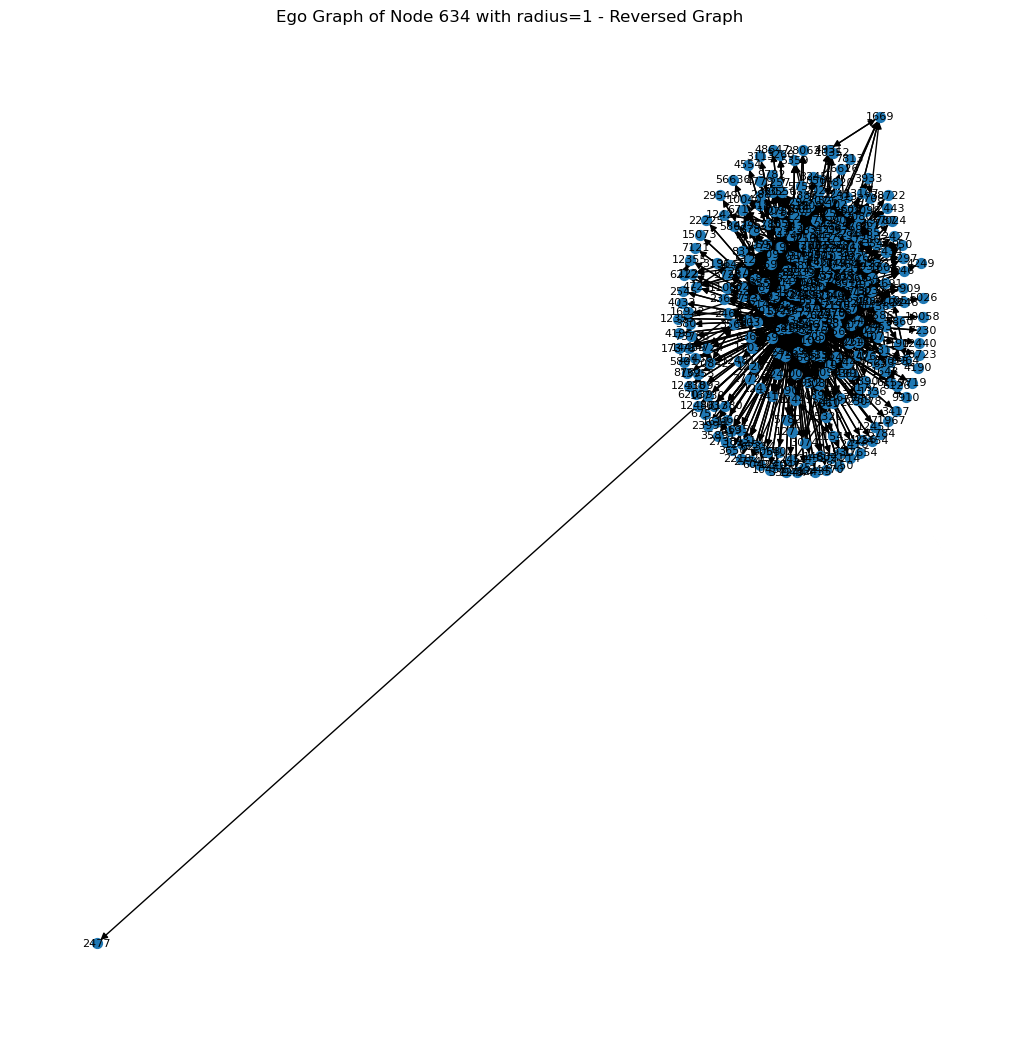

In [69]:
node_of_interest = 634
subgraph = nx.ego_graph(reversed_graph, node_of_interest, radius=1)

# Plot the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph, with_labels=True, node_size=50, font_size=8)
plt.title(f"Ego Graph of Node {node_of_interest} with radius=1 - Reversed Graph")
plt.show()

In [ ]:
## Adiacent Heatmap

import numpy as np
import seaborn as sns

# Create adjacency matrix (convert to numpy)
A = nx.to_numpy_array(core_G)

# Plot heatmap of a subset (e.g., top 500 nodes)
subset = A[:500, :500]
sns.heatmap(subset, cmap='viridis')
plt.title("Adjacency Matrix Heatmap (Subset)")
plt.show()


In [ ]:
nx.draw_networkx(G, node_size=1000, node_color='lightblue', with_labels=True, font_size=8)

# Simulation

In [30]:
# Simulation setup
def initial_state(G, hubs):
    state = {}
    for node in G.nodes:
        state[node] = 'asleep'
    for hub in hubs:  # Set the hubs to 'awake' initially
        state[hub] = 'awake'
    return state

# State transition function
P_AWAKEN = 0.2
P_HUB_INFLUENCE = 0.5

def state_transition(G, current_state):
    next_state = current_state.copy()
    for node in G.nodes:
        if current_state[node] == 'asleep':
            neighbors = list(G.predecessors(node))
            influenced = any(current_state[neighbor] == 'awake' for neighbor in neighbors)
            if influenced and random.random() < P_HUB_INFLUENCE:
                next_state[node] = 'awake'
            elif random.random() < P_AWAKEN:
                next_state[node] = 'awake'
    return next_state

In [ ]:
from simulation import Simulation

# Simulation setup
def initial_state(G, hubs):
    state = {}
    for node in G.nodes:
        state[node] = 'asleep'
    for hub in hubs:  # Set the hubs to 'awake' initially
        state[hub] = 'awake'
    return state

# State transition function
P_AWAKEN = 0.2
P_HUB_INFLUENCE = 0.5

def state_transition(G, current_state):
    next_state = current_state.copy()
    for node in G.nodes:
        if current_state[node] == 'asleep':
            neighbors = list(G.predecessors(node))
            influenced = any(current_state[neighbor] == 'awake' for neighbor in neighbors)
            if influenced and random.random() < P_HUB_INFLUENCE:
                next_state[node] = 'awake'
            elif random.random() < P_AWAKEN:
                next_state[node] = 'awake'
    return next_state

hubs = [hub[0] for hub in reverse_hubs["top_in_out_degree"]]  # Extract hub node IDs

# Run the simulation
sim = Simulation(G, lambda G: initial_state(G, hubs), state_transition, name='Hub Influence Simulation')

# Display initial state
print("Initial State:")
display_state(sim.state())

# Run and display results
sim.run(10)

print("\nFinal State:")
display_state(sim.state())

sim.plot()
plt.grid()
plt.show()


### voter model

In [54]:
def initial_state(G):
    state = {}
    for node in G.nodes:
        state[node] = random.choice('ABCDE')
    return state

In [55]:
def state_transition(G, current_state):
    next_state = {}
    for node in G.nodes:
        # Caveat: what if the node has no neighbors?
        if G.degree(node) > 0:
            neighbor = random.choice(list(G.neighbors(node)))
            next_state[node] = current_state[neighbor]
    return next_state

In [56]:
initial_state = initial_state(reversed_core_G)
S = state_transition(reversed_core_G, initial_state)
display_state(S)

A : [4, 19, 20, 25, 33, 34, 49, 51, 78, 81, 87, 102, 103, 117, 119, 128, 140, 141, 233, 550, 588, 681, 720, 725, 728, 730, 413, 783, 848, 165, 319, 367, 549, 766, 1173, 1182, 1191, 383, 746, 879, 1029, 350, 684, 853, 1406, 1712, 1719, 432, 440, 1738, 745, 1476, 1975, 2030, 429, 2118, 1440, 442, 455, 579, 1037, 1933, 2075, 2265, 2373, 217, 704, 618, 637, 1483, 3174, 2144, 492, 2980, 1596, 1225, 3234, 4202, 3850]
B : [0, 10, 28, 31, 39, 43, 50, 54, 59, 60, 77, 79, 89, 92, 110, 111, 113, 116, 120, 136, 223, 310, 388, 551, 721, 724, 727, 729, 733, 735, 2, 225, 237, 366, 421, 563, 789, 917, 1164, 345, 411, 414, 415, 418, 559, 586, 620, 852, 1167, 1174, 1179, 195, 357, 410, 1274, 428, 860, 1314, 1111, 1207, 349, 143, 1748, 556, 187, 234, 340, 370, 381, 431, 975, 1016, 1935, 2037, 2062, 1620, 2227, 154, 942, 2303, 652, 2512, 296, 360, 2528, 1224, 1432, 2656, 212, 215, 2174, 297, 4565, 2729, 634]
C : [5, 35, 37, 38, 53, 55, 61, 63, 66, 73, 90, 97, 98, 100, 101, 112, 118, 122, 135, 169, 433, 54

In [58]:
sim = Simulation(reversed_core_G, initial_state, state_transition, name='Voter Model')

display_state(sim.state())

A : [4, 26, 30, 31, 40, 44, 58, 59, 63, 69, 73, 75, 77, 85, 108, 113, 122, 124, 169, 310, 333, 368, 427, 433, 551, 681, 719, 725, 729, 235, 249, 398, 438, 782, 793, 301, 408, 418, 663, 766, 1173, 357, 407, 410, 1029, 193, 428, 1036, 1398, 854, 1576, 849, 1738, 1755, 556, 1903, 340, 844, 2030, 320, 145, 167, 291, 447, 455, 2075, 2373, 217, 289, 481, 1024, 2408, 2512, 1224, 1225, 4558, 1059, 71399]
B : [10, 19, 27, 28, 35, 43, 49, 60, 72, 81, 105, 107, 109, 119, 123, 136, 401, 426, 449, 550, 720, 721, 723, 724, 726, 733, 735, 737, 738, 155, 236, 413, 664, 780, 794, 547, 159, 917, 1163, 319, 345, 395, 411, 549, 1172, 1179, 6, 546, 629, 879, 954, 382, 1304, 1312, 1314, 1023, 1716, 1754, 1909, 1016, 1476, 1935, 1975, 2037, 2043, 2046, 2062, 429, 552, 2115, 2120, 2227, 154, 326, 400, 1933, 2265, 637, 1432, 2151, 2651, 198, 640, 1460, 2710, 1283, 215, 802, 1152, 4313, 2980, 1596, 514, 1619, 279]
C : [0, 24, 25, 34, 37, 48, 53, 54, 55, 87, 92, 97, 102, 127, 128, 1, 223, 545, 717, 722, 730, 2, 

In [75]:
sim.run(40)
display_state(sim.state())

C : [0, 4, 5, 10, 11, 12, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 37, 38, 39, 40, 43, 44, 45, 48, 49, 50, 51, 53, 54, 55, 58, 59, 60, 61, 63, 65, 66, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 83, 85, 87, 88, 89, 90, 92, 93, 96, 97, 98, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 116, 117, 118, 119, 120, 122, 123, 124, 125, 127, 128, 130, 132, 135, 136, 140, 141, 1, 169, 223, 233, 295, 310, 333, 335, 368, 388, 401, 409, 426, 427, 433, 449, 545, 550, 551, 588, 639, 681, 715, 717, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 733, 735, 737, 738, 2, 155, 225, 235, 236, 237, 249, 366, 369, 398, 402, 413, 421, 437, 438, 443, 445, 555, 563, 625, 664, 683, 776, 779, 780, 782, 783, 786, 787, 789, 790, 792, 793, 794, 547, 159, 843, 848, 917, 923, 1163, 1164, 165, 301, 312, 319, 345, 354, 367, 384, 385, 395, 408, 411, 414, 415, 418, 549, 559, 586, 620, 663, 766, 852, 993, 1167, 1172, 1173, 1174, 1178, 1179, 1181, 1182, 1191, 6, 195,

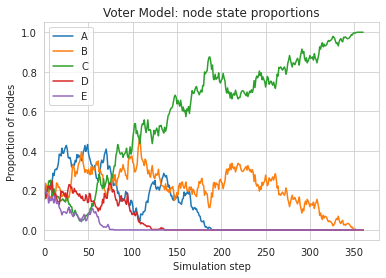

In [76]:
sim.plot(labels="ABCDE")
plt.show()

asynchronous update

In [77]:
def state_transition_async(G, current_state):
    # Randomizing the update order prevents bias
    nodes_to_update = list(G.nodes)
    random.shuffle(nodes_to_update)
    for node in nodes_to_update:
        if G.degree(node) > 0:
            neighbor = random.choice(list(G.neighbors(node)))
            current_state[node] = current_state[neighbor]
    return current_state

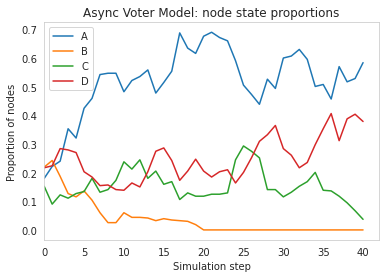

In [78]:
sim = Simulation(reversed_core_G, initial_state, state_transition_async, name='Async Voter Model')


In [81]:
sim.run(40)

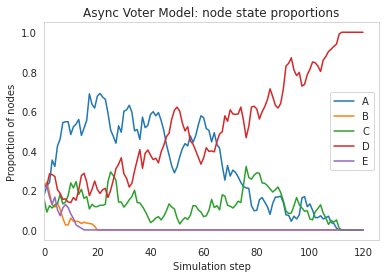

In [82]:
sim.plot(labels="ABCDE")
plt.grid()
plt.show()

## Rewiring

In [83]:
def state_transition_async_rewiring(G, current_state):
    # Randomizing the update order prevents bias
    nodes_to_update = list(G.nodes)
    random.shuffle(nodes_to_update)
    for node in nodes_to_update:
        if G.degree(node) > 0:
            # This is the same as before
            neighbor = random.choice(list(G.neighbors(node)))
            current_state[node] = current_state[neighbor]
            # This is the new part
            neighbor = random.choice(list(G.neighbors(node)))
            if current_state[node] != current_state[neighbor]:
                G.remove_edge(node, neighbor)
            
    return current_state

In [ ]:
sim = Simulation(reversed_core_G, initial_state, state_transition_async_rewiring,
                 name='Voter Model with rewiring')

In [86]:
sim.run(60)

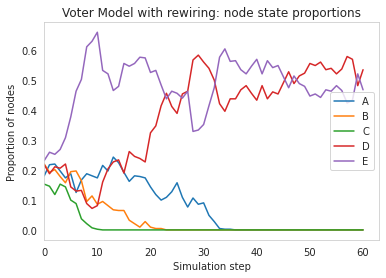

In [87]:
sim.plot(labels="ABCDE")
plt.grid()
plt.show()

Regarding partitions, below there is a function that verify if the nodes are in the same partitions.

In [ ]:
#This function verify if the nodes are in the same partitions:

def make_partition_map(partition):
    partition_map = {}
    for idx, cluster_nodes in enumerate(partition):
        for node in cluster_nodes:
            partition_map[node] = idx
    return partition_map

False
True
False
True
True


# Create the Adjacencies and the Laplacian of a Graph

Now it will be created the adjaceny and laplacian matrix from the set of nodes.

In [9]:
def compute_graph_matrices(core_graph):
    """
    Computes the adjacency, degree, and Laplacian matrices for a core graph.

    Parameters:
    - core_graph: A NetworkX DiGraph (the core graph)

    Returns:
    - adjacency_matrix: A NumPy array (core_graph size x core_graph size)
    - degree_matrix: A sparse diagonal matrix (scipy.sparse)
    - laplacian_matrix: A sparse Laplacian matrix (scipy.sparse)
    - core_nodes: A list of node labels in the order they appear in the matrix
    """
    # Get the nodes of the core graph sorted by their original labels
    core_nodes = sorted(core_graph.nodes)
    node_mapping = {node: idx for idx, node in enumerate(core_nodes)}
    
    # Initialize adjacency matrix of size (core_graph size x core_graph size)
    size = len(core_nodes)
    adjacency_matrix = np.zeros((size, size))
    
    # Populate the adjacency matrix
    for u, v in core_graph.edges:
        adjacency_matrix[node_mapping[u], node_mapping[v]] = 1  # Directed edge from u to v

    # Compute the degree for each node (sum of rows in the adjacency matrix)
    degrees = np.sum(adjacency_matrix, axis=1)
    
    # Create the degree matrix as a sparse diagonal matrix
    degree_matrix = diags(degrees, offsets=0, format="csr")
    
    # Compute the Laplacian matrix
    laplacian_matrix = degree_matrix - csr_matrix(adjacency_matrix)

    return adjacency_matrix, degree_matrix, laplacian_matrix, core_nodes

In [ ]:
adjacency_matrix, degree_matrix, laplacian_matrix, core_nodes = compute_graph_matrices(core_G)

print(laplacian_matrix.shape)

(23503, 23503)


And now eigenvalues and eigenvectors of Laplacian matrix

### DO NOT RUN IT ANYMORE
the eigenvalues and eigenvector are already compute and they're stored in the .npz file

In [ ]:
# Number of eigenvalues/vectors to compute

k = core_G.number_of_nodes()

start_time = time.time()
# Compute eigenvalues and eigenvectors using ARPACK via eigsh
eigenvalues, eigenvectors = linalg.eigsh(laplacian_matrix.toarray(), k=k, which='SM')  # SM: smallest magnitude
elapsed_time = time.time() - start_time

print (elapsed_time)

# Output results
# print("Eigenvalues:", eigenvalues)
print("Eigenvectors (shape):", eigenvectors.shape)

eigenvectors = eigenvectors.astype(np.float32)
eigenvalues = eigenvalues.astype(np.float32)

# Save the results to a file
np.savez_compressed("eigenvalues_eigenvectors.npz", eigenvalues=eigenvalues, eigenvectors=eigenvectors)

print("Eigenvalues and eigenvectors have been saved to 'eigenvalues_eigenvectors.npz'")

Restore eigenvalues and eigenvectors

In [50]:
data = np.load("eigenvalues_eigenvectors.npz")
eigenvalues = data['eigenvalues'].astype(np.float32)
eigenvectors = data['eigenvectors'].astype(np.float32)

Eigenvalues plots

In [ ]:
eord = np.argsort(eigenvalues)
L1=eigenvectors[:,eord[0]]
L2=eigenvectors[:,eord[1]]
plt.plot(core_G.nodes, L1, ".--", label="Eigen 1")
plt.plot(core_G.nodes, L2, ".--", label="Eigen 2")
plt.ylim(-1,1)
plt.grid()
plt.legend()
plt.show()

In [ ]:
def plotEigenVector(LL):
    NN=LL.shape[0]
    n_order=np.argsort(LL)
    plt.plot(np.arange(NN), LL[n_order], ".--")

    for x,y in zip(np.arange(NN), LL[n_order]):
        plt.annotate(core_G.nodes[n_order[x]], (x,y), textcoords="offset points",
                     xytext=(0,3), ha='center', size=6)
    plt.grid()
    plt.show()
    
plotEigenVector(L2)

# Louvain Analysis

In [2]:
dl_obj = dl.Community("soc-Epinions1.txt", precision=0.0001, gamma=1, reproducibility=False, renumbering=True, random=False)

In [3]:
import contextlib
output=open("logcom", "w")
with contextlib.redirect_stdout(output):
    dl_obj.run(verbose=True)
output.close()

level 0:
  network size: 75879 nodes, 

508841 arcs, 584717 weight.
  modularity increased from -0.0171296 to 0.372264
level 1:
  network size: 8148 nodes, 34988 arcs, 584717 weight.
  modularity increased from 0.372264 to 0.521522
level 2:
  network size: 2785 nodes, 11884 arcs, 584717 weight.
  modularity increased from 0.521522 to 0.523204
level 3:
  network size: 2102 nodes, 7390 arcs, 584717 weight.
  modularity increased from 0.523204 to 0.523442
level 4:
  network size: 1972 nodes, 6110 arcs, 584717 weight.
  modularity increased from 0.523442 to 0.523455
level 5:
  network size: 1959 nodes, 5933 arcs, 584717 weight.
  modularity increased from 0.523455 to 0.523456
level 6:
  network size: 1958 nodes, 5917 arcs, 584717 weight.
  modularity increased from 0.523456 to 0.523456


# Get the node-to-community mapping for the last level into nodecomm.txt.

It didn't work on python for a problem of the shared object file, which gives a segmentation fault error. Anyway, I runned it on c++ and I get the result, so we just need to import the file

In [ ]:
# output=open("nodecomm.txt", "w")
# with contextlib.redirect_stdout(output):
#     dl_obj.print_level(-2)
# output.close()